Regression 

mainly in DMN

In [2]:
import sys
sys.path.append("../mypkg")

In [1]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl
from utils.colors import qual_cmap

ModuleNotFoundError: No module named 'constants'

In [ ]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [ ]:
import numpy as np
import scipy
from scipy.io import loadmat
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
import bct # the pkg to get graph features
from joblib import Parallel, delayed
from easydict import EasyDict as edict
import pandas as pd

plt.style.use(FIG_ROOT/'base.mplstyle')

# Fns and params

## Some fns

In [ ]:
from prettytable import PrettyTable as PT
from scipy.stats import f_oneway, ttest_ind 

def _get_test_tb(res_df):
    tb = PT()
    tb.field_names = ["Test", "Pval", "Effect size"]
    
    HC = res_df["metric"][res_df["diagnosis"]==6]
    
    def indicator(pval):
        if pval < 0.05:
            return "*"
        else:
            return ""
    # list all disease
    for diag_ix in range(1, 6):
        DS = res_df["metric"][res_df["diagnosis"]==diag_ix]
        ttest_res = ttest_ind(DS, HC)
        effect_size = (np.mean(DS)-np.mean(HC))/np.std(np.concatenate([DS, HC]), ddof=2)
        tb.add_row([f"{indicator(ttest_res.pvalue)}{diag_lab_mapping[diag_ix]} vs HC", 
                      f"{ttest_res.pvalue:>6.3f}", 
                      f"{effect_size:>6.3f}"])
    
    # pool 5 diseases together
    DS = res_df["metric"][res_df["diagnosis"]!=6]
    ttest_res = ttest_ind(DS, HC)
    effect_size = (np.mean(DS)-np.mean(HC))/np.std(np.concatenate([DS, HC]), ddof=2)
    tb.add_row([f"{indicator(ttest_res.pvalue)}Dementia vs HC", 
                f"{ttest_res.pvalue:>6.3f}", 
                f"{effect_size:>6.3f}"])
    
    # anova
    metric_grp = [res_df["metric"][res_df["diagnosis"]==grp_ix] for grp_ix in range(1, 7)]
    anova_res = f_oneway(*metric_grp)
    tb.add_row([f"{indicator(anova_res.pvalue)}ANOVA", 
                f"{anova_res.pvalue:>6.3f}", 
                f""])
    tb.align["Test"] = "r"
    tb.align["Pval"] = "c"
    tb.align["Effect size"] = "c"
    return tb

In [ ]:
def _preprocess_ts(ts):
    """preprocessing, 
        1. detrend
        2. resample (len of seq has 235 or 555, I make it consistent to 235)
    """
    ts = signal.detrend(ts);
    if ts.shape[-1] > 235:
        ts = signal.resample(ts, num=235, axis=-1)
    return ts
    
    
def _load_data(n):
    """Sub idx is from 1, n: the sub idx
    """
    return mat_data['ts_321_273'][np.where(mat_data['subj_321_ts'][:, 0] == n)[0], :].transpose()

## Load data and params

In [7]:
# load data
mat_data = loadmat(DATA_ROOT/"ad_ftd_hc_fmri_data.mat");

diag_labs = mat_data["dx_321"].reshape(-1)
sex_labs = mat_data["sex_321"].reshape(-1)
diag_lab_mapping = {
 1: "AD",
 2: "bvFTD",
 3: "CBS", 
 4: "nfvPPA", 
 5: "svPPA", 
 6: "HC"
}

# some parameters

num_rois = 246 # the BNA has 246 regions
num_sps = 321

labs = pd.read_csv(DATA_ROOT/"BN246_RegionList.csv");
yeo_7nets_lab = np.array(labs["Yeo_7network"][:246]);

yeo_7nets_dict = pd.read_csv(DATA_ROOT/"yeo_7nets_dict.txt");
yeo_7nets_dict = {yeo_7nets_dict["lab"][ix]:"_".join(yeo_7nets_dict["name"][ix].strip().split(" "))
                  for ix in range(7)}
yeo_7nets_ts = load_pkl(DATA_ROOT/"ad_ftd_hc_fmri_data_7nets.pkl");

Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../data/ad_ftd_hc_fmri_data_7nets.pkl


In [8]:
# Load features
net_ix = 7
graph_metrics = load_pkl(RES_ROOT/f"graph_metrics_fc_fisher_abs_{yeo_7nets_dict[net_ix]}.pkl");
tvdn_rks = np.array(load_pkl(RES_ROOT/f"tvdnMaxM20_ranks_{yeo_7nets_dict[net_ix]}.pkl"));
tvdn_ecptss = load_pkl(RES_ROOT/f"tvdnMaxM20_ecptss_kp1647_{yeo_7nets_dict[net_ix]}.pkl");

Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/graph_metrics_fc_fisher_abs_Default.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdnMaxM20_ranks_Default.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdnMaxM20_ecptss_kp1647_Default.pkl


In [9]:
tvdn_ncpts = np.array([len(ecpts) for ecpts in tvdn_ecptss]);
graph_C = np.array([metric.network_metrics["tmC"] for metric in graph_metrics])
graph_L = np.array([metric.network_metrics["tmL"] for metric in graph_metrics])
graph_Q = np.array([metric.network_metrics["tQ"] for metric in graph_metrics]);
sgm_res = load_pkl(RES_ROOT/"sgm_all_res.pkl");

In [10]:
Xs = np.vstack([tvdn_rks, tvdn_ncpts, 
                graph_C, graph_L, graph_Q]).T;

In [11]:

stdX_fn = lambda Xs: (Xs - Xs.mean(axis=0, keepdims=1))/Xs.std(axis=0, keepdims=1)

<function __main__.<lambda>(Xs)>

# Regression

In [11]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import statsmodels.api as sm
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import roc_auc_score, roc_curve

In [12]:
def _LOO_CV(Xs, Y, model, verbose=False):
    loo = LeaveOneOut()
    eprobs = []
    if verbose:
        pbar = tqdm(loo.split(Xs), total=len(Y))
    else:
        pbar = loo.split(Xs)
    for train_idx, test_idx in pbar:
        X_train, X_test = Xs[train_idx], Xs[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]
        
        # std X
        X_train_m = X_train.mean(axis=0, keepdims=1)
        X_train_std = X_train.std(axis=0, keepdims=1)
        X_train = (X_train-X_train_m)/X_train_std
        X_test = (X_test-X_train_m)/X_train_std
        
        clf = model.fit(X_train, y_train)
        if len(np.unique(Y)) == 2:
            eprobs.append(clf.predict_proba(X_test))
        else:
            eprobs.append(clf.predict(X_test))
    return np.concatenate(np.array(eprobs))

## Logi (All disease vs HC)

In [17]:
Y = np.array(diag_labs);
Y[Y==6] = 0
Y[Y>0] = 1

model = LogisticRegression(random_state=0, C=10)

LogisticRegression(C=10, random_state=0)

In [18]:
eprobs = _LOO_CV(Xs, Y, model, verbose=True);
auc = roc_auc_score(Y, eprobs[:, 1])
fpr, tpr, thresholds = roc_curve(Y, eprobs[:, 1], pos_label=1)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 344.40it/s]


Text(0.5, 1.0, 'Disease vs HC (AUC:0.629)')

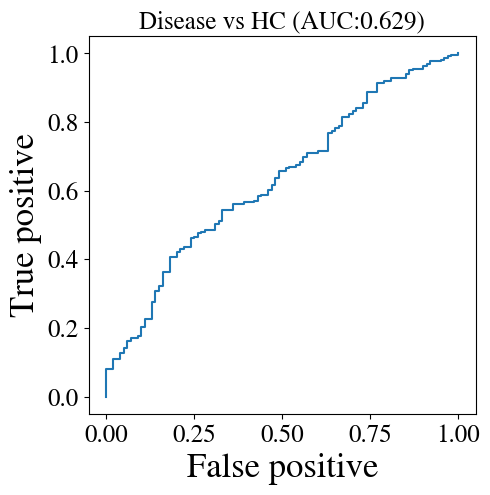

In [19]:
plt.figure(figsize=[5, 5])
plt.plot(fpr, tpr)
plt.xlabel("False positive")
plt.ylabel("True positive")
plt.title(f"Disease vs HC (AUC:{auc:.3f})")

## Each vs HC

In [17]:
result_all = {}
for disease_ix in range(1, 6):
    kp_idxs = np.bitwise_or(diag_labs==disease_ix, diag_labs==6);
    cur_Xs = Xs[kp_idxs]
    cur_Y = diag_labs[kp_idxs];
    cur_Y[cur_Y==disease_ix] = 1
    cur_Y[cur_Y==6] = 0
    model = LogisticRegression(random_state=0, C=1)
    cur_eprobs = _LOO_CV(cur_Xs, cur_Y, model, verbose=True);
    auc = roc_auc_score(cur_Y, cur_eprobs[:, 1])
    fpr, tpr, thresholds = roc_curve(cur_Y, cur_eprobs[:, 1], pos_label=1)
    result_all[disease_ix] = edict()
    result_all[disease_ix].eprobs = cur_eprobs
    result_all[disease_ix].auc = auc
    result_all[disease_ix].fpr = fpr 
    result_all[disease_ix].tpr = tpr 
    result_all[disease_ix].thre = thresholds

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 137/137 [00:00<00:00, 410.71it/s]


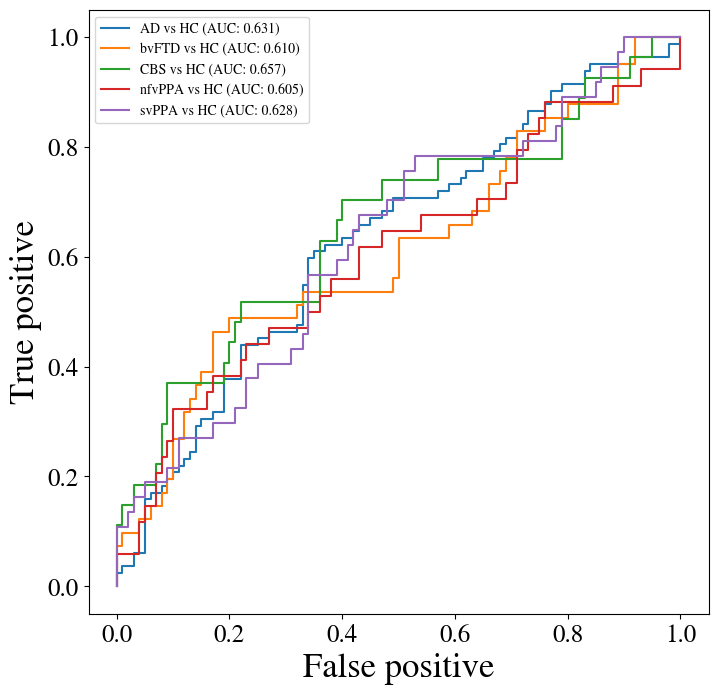

In [18]:
plt.figure(figsize=[8, 8])
for disease_ix in range(1, 6):
    plt.plot(
        result_all[disease_ix].fpr, 
        result_all[disease_ix].tpr, 
        label=f"{diag_lab_mapping[disease_ix]} vs HC (AUC: {result_all[disease_ix].auc:.3f})"
    )
    
plt.xlabel("False positive")
plt.ylabel("True positive")
plt.legend(fontsize=10)

## Mutinomial regression

In [19]:
from sklearn.metrics import confusion_matrix

In [20]:
Y = np.array(diag_labs)
model = LogisticRegression(random_state=0, C=1)

LogisticRegression(C=1, random_state=0)

In [21]:
pred_Y = _LOO_CV(Xs, Y, model, verbose=True);

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:18<00:00, 17.34it/s]


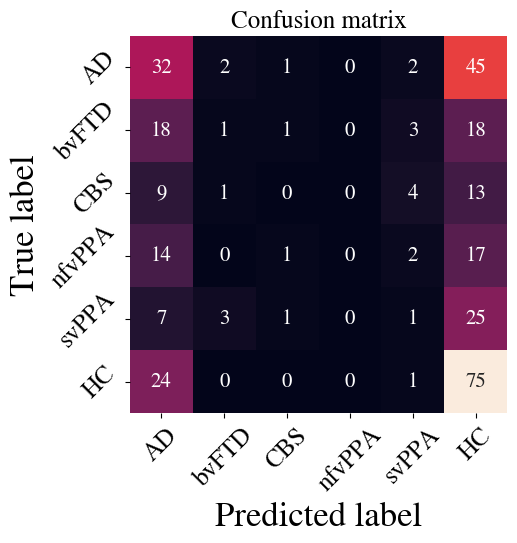

In [22]:
cm = confusion_matrix(Y, pred_Y);
sns.heatmap(cm, annot=True, square=True, cbar=False)
plt.yticks(np.arange(6)+0.5, 
           [diag_lab_mapping[disease_ix] for disease_ix in range(1, 7)], 
          rotation=45)
plt.xticks(np.arange(6)+0.5, 
           [diag_lab_mapping[disease_ix] for disease_ix in range(1, 7)], 
          rotation=45)
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.title("Confusion matrix");

# Regression inference

In [12]:
import statsmodels.api as sm
from scipy.stats import ttest_ind, mannwhitneyu

In [67]:
Xs = np.vstack([tvdn_ncpts, graph_C, 
                graph_L, graph_Q]).T;

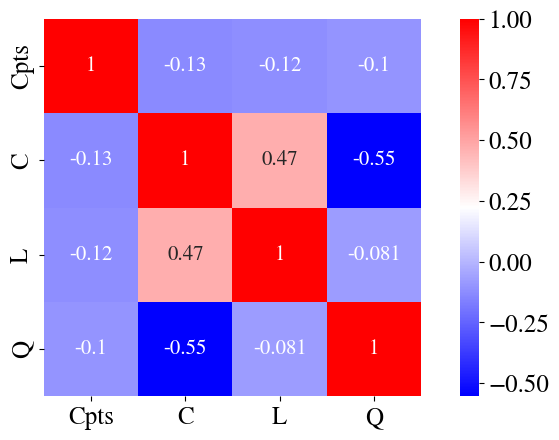

In [68]:
kp_idxs = np.bitwise_or(diag_labs==1, diag_labs==6);
cur_Xs = Xs[kp_idxs]
sns.heatmap(np.corrcoef(cur_Xs.T), annot=True, square=True, cmap="bwr")
plt.xticks(np.arange(4)+0.5, ["Cpts", "C", "L", "Q"])
plt.yticks(np.arange(4)+0.5, ["Cpts", "C", "L", "Q"]);

In [56]:
result_all = {}
for disease_ix in range(1, 6):
    kp_idxs = np.bitwise_or(diag_labs==disease_ix, diag_labs==6);
    cur_Xs = Xs[kp_idxs]
    cur_Y = diag_labs[kp_idxs];
    cur_Y[cur_Y==disease_ix] = 1
    cur_Y[cur_Y==6] = 0
    std_cur_Xs = stdX_fn(cur_Xs)
    #model = sm.OLS(cur_Y, sm.add_constant(std_cur_Xs))
    model = sm.Logit(cur_Y, sm.add_constant(std_cur_Xs))
    results = model.fit()
    table1 = results.summary().tables[0]
    table = results.summary().tables[1]
    table_df = pd.DataFrame(table.data[1:], columns=table.data[0])
    table_df.iloc[:, 0] =  ["Constant"] + ["CPT", "C", "L", "Q"]
    #table_df.iloc[:, 0] =  ["Constant"] + ["Rank", "CPT", "C", "L", "Q"]
    
    results = model.fit()
    result_all[disease_ix] = edict()
    result_all[disease_ix].table1 = pd.DataFrame(table1)
    result_all[disease_ix].table2 = table_df


Optimization terminated successfully.
         Current function value: 72.068711
         Iterations 5
Optimization terminated successfully.
         Current function value: 72.068711
         Iterations 5
Optimization terminated successfully.
         Current function value: 215.559113
         Iterations 5
Optimization terminated successfully.
         Current function value: 215.559113
         Iterations 5
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6
Optimization terminated successfully.
         Current function value: inf
         Iterations 6


/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/opt/conda/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:3500: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/opt/conda/lib/python3.9/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn

In [57]:
for disease_ix in range(1, 6):
    print(diag_lab_mapping[disease_ix])
    display(result_all[disease_ix].table2)

AD


,,coef,std err,z,P>|z|,[0.025,0.975]
0,Constant,-0.2050,0.157,-1.304,0.192,-0.513,0.103
1,CPT,-0.3479,0.169,-2.062,0.039,-0.679,-0.017
2,C,0.3839,0.229,1.676,0.094,-0.065,0.833
3,L,0.2395,0.186,1.290,0.197,-0.125,0.604
4,Q,-0.0488,0.199,-0.246,0.806,-0.438,0.340


bvFTD


,,coef,std err,z,P>|z|,[0.025,0.975]
0,Constant,-0.9956,0.204,-4.889,0.000,-1.395,-0.597
1,CPT,-0.0962,0.188,-0.512,0.608,-0.464,0.272
2,C,0.4907,0.264,1.855,0.064,-0.028,1.009
3,L,0.3976,0.239,1.666,0.096,-0.070,0.865
4,Q,-0.0666,0.235,-0.283,0.777,-0.528,0.395


CBS


,,coef,std err,z,P>|z|,[0.025,0.975]
0,Constant,-1.5365,0.257,-5.979,0.000,-2.040,-1.033
1,CPT,0.1272,0.249,0.512,0.609,-0.360,0.615
2,C,-0.0930,0.296,-0.314,0.753,-0.673,0.487
3,L,0.8401,0.285,2.947,0.003,0.281,1.399
4,Q,-0.5188,0.291,-1.780,0.075,-1.090,0.052


nfvPPA


,,coef,std err,z,P>|z|,[0.025,0.975]
0,Constant,-1.1948,0.218,-5.471,0.000,-1.623,-0.767
1,CPT,0.1505,0.218,0.690,0.490,-0.277,0.578
2,C,0.1660,0.274,0.605,0.545,-0.372,0.703
3,L,0.5970,0.252,2.366,0.018,0.103,1.092
4,Q,-0.1425,0.254,-0.561,0.575,-0.640,0.355


svPPA


,,coef,std err,z,P>|z|,[0.025,0.975]
0,Constant,-1.1190,0.214,-5.222,0.000,-1.539,-0.699
1,CPT,0.3940,0.255,1.543,0.123,-0.107,0.895
2,C,-0.1577,0.282,-0.559,0.576,-0.711,0.395
3,L,0.7352,0.260,2.830,0.005,0.226,1.244
4,Q,-0.4162,0.263,-1.585,0.113,-0.931,0.098


In [24]:
kp_idxs = np.bitwise_or(diag_labs==1, diag_labs==6);
cur_Y = diag_labs[kp_idxs];
cur_Xs = Xs[kp_idxs];
cur_X = cur_Xs[:, 3]
vec1, vec2 = cur_X[cur_Y==1], cur_X[cur_Y==6]
test_res = mannwhitneyu(vec1, vec2)
#test_res2 = ttest_ind(vec1, vec2)

MannwhitneyuResult(statistic=5051.0, pvalue=0.007190670322924517)